In [752]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [753]:
cwd = os.getcwd()
data_file_name = "/day.csv"
dataset = pd.read_csv(cwd + data_file_name)
dataset.shape #(731, 16)

(731, 16)

In [754]:
# convert string to datetime
dataset.dteday = dataset.dteday.apply(lambda x:pd.to_datetime(x))
dataset = dataset.drop(['instant'], axis = 1)

In [755]:
# calculate the ahead n-7 to n-2 days average number
def calcAvgShift(dfCol, period, exclude):
    try:
        summary = dfCol.rolling(period).mean()
        if period is None:
            return dfCol
        if exclude is None:
            return summary
        mean = dfCol.shift(exclude).rolling(period, 1).mean()
        return mean.apply(lambda x: round(x, 3))
    except Exception as e:
        print("error:" + str(e))

In [756]:
# dataset['cnt_lag2'] = dataset['cnt'].shift(2)
dataset['casual_lag2'] = dataset['casual'].shift(2)
dataset['regist_lag2'] = dataset['registered'].shift(2)
dataset['casual_avg_aheadWeek'] = calcAvgShift(dataset.casual, 7, 2)
dataset['regist_avg_aheadWeek'] = calcAvgShift(dataset.registered, 7, 2)
dataset['casual_avg_aheadMonth'] = calcAvgShift(dataset.casual, 31, 2)
dataset['regist_avg_aheadMonth'] = calcAvgShift(dataset.registered, 31, 2)
dataset['casual_lastWeekday'] = dataset.casual.shift(7)
dataset['regist_lastWeekday'] = dataset.registered.shift(7)


In [757]:
dataset['casual_inc_ratio'] = ((dataset['casual'] - dataset['casual_lag2']) / dataset['casual_lag2']).apply(lambda x:round(x, 3))
dataset['regist_inc_ratio'] = ((dataset['registered'] - dataset['regist_lag2']) / dataset['regist_lag2']).apply(lambda x:round(x, 3))


In [759]:
dataset
dataset.to_csv("./totalBikeSharing.csv", index=False)

In [761]:
dataset.columns.values

array(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'casual_lag2', 'regist_lag2',
       'casual_avg_aheadWeek', 'regist_avg_aheadWeek',
       'casual_avg_aheadMonth', 'regist_avg_aheadMonth',
       'casual_lastWeekday', 'regist_lastWeekday', 'casual_inc_ratio',
       'regist_inc_ratio'], dtype=object)

In [683]:
dummy_season = pd.get_dummies(dataset.season, prefix="season")
dummy_weathersit = pd.get_dummies(dataset.weathersit, prefix="weathersit")

In [684]:
dataset = pd.concat([dataset, dummy_season, dummy_weathersit], axis = 1)

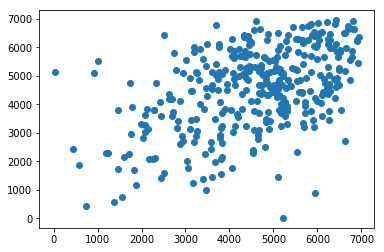

In [698]:
from sklearn.metrics import mean_squared_error
lag2 = dataset[dataset.dteday > datetime(2011, 12, 31)]['regist_lag2']
currt = dataset[dataset.dteday > datetime(2011, 12, 31)]['registered']
mse = mean_squared_error(lag2, currt)
mse
plt.figure()
plt.scatter(dataset[dataset.dteday > datetime(2011, 12, 31)]['regist_lag2'], dataset[dataset.dteday > datetime(2011, 12, 31)]['registered'])
plt.show()

In [699]:
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'casual_lag2', 'regist_lag2',
       'avg_casual_aheadWeek', 'avg_regist_aheadWeek',
       'avg_casual_aheadMonth', 'avg_regist_aheadMonth',
       'lastWeekday_casual', 'lastWeekday_regist']

In [701]:
train = dataset[dataset.dteday < datetime(2012, 1, 1)]
test = dataset[dataset.dteday > datetime(2011, 12, 31)]
y_train_register = train.registered
y_test_register = test.registered

In [688]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train[numerical_cols])
train[numerical_cols] = scaler.transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [702]:
drop_col = ['dteday', 'yr', 'mnth', 'weekday', 'season', 'weathersit', 'cnt', 'registered']

In [703]:
train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)




In [704]:
train.columns.values

array(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'casual_lag2', 'regist_lag2', 'avg_casual_aheadWeek',
       'avg_regist_aheadWeek', 'avg_casual_aheadMonth',
       'avg_regist_aheadMonth', 'lastWeekday_casual',
       'lastWeekday_regist', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3'],
      dtype=object)

In [706]:
from sklearn import tree
drops = ['casual', \
                      'casual_lag2', 'avg_casual_aheadWeek', \
                      'avg_casual_aheadMonth', 'lastWeekday_casual']
train_y = train['registered']
train_x = train.drop(drops, axis = 1)
test_y = test['registered']
test_x = test.drop(drops, axis = 1)

KeyError: 'registered'

In [ ]:
# y_train_register = train.registered
# y_test_register = test.registered

In [726]:
clf = tree.DecisionTreeRegressor(max_depth=9)
clf = clf.fit(train_x, y_train_register[7:, ])
dt_test_predict = clf.predict(test_x)


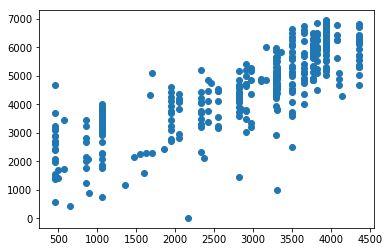

In [727]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(dt_test_predict, y_test_register)
plt.show()

In [711]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [712]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr = regr.fit(train_x, y_train_register[7:, ])
rf_test_prediction = regr.predict(test_x)

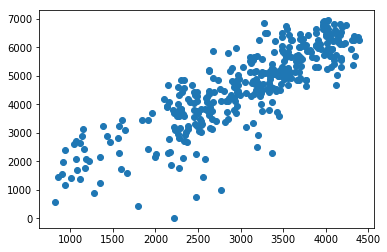

In [723]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(rf_test_prediction, y_test_register)
plt.show()

In [722]:
mse = mean_squared_error(rf_test_prediction *1.5, y_test_register)
mse**(0.5)

763.7595125868744

Feature ranking:
1. feature 7 (0.354694)
2. feature 8 (0.130683)
3. feature 10 (0.127063)
4. feature 1 (0.086496)
5. feature 3 (0.079284)
6. feature 4 (0.059502)
7. feature 16 (0.042433)
8. feature 5 (0.033951)
9. feature 2 (0.030039)
10. feature 6 (0.025759)
11. feature 9 (0.015617)
12. feature 15 (0.004990)
13. feature 14 (0.004963)
14. feature 13 (0.003287)
15. feature 0 (0.000628)
16. feature 11 (0.000321)
17. feature 12 (0.000290)


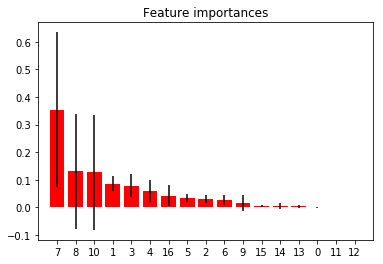

In [657]:
importances = regr.feature_importances_
importances
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(test_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(test_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_x.shape[1]), indices)
plt.xlim([-1, test_x.shape[1]])
plt.show()

In [658]:
test_x.columns.values

array(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'regist_lag2', 'avg_regist_aheadWeek', 'avg_regist_aheadMonth',
       'lastWeekday_regist', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3'],
      dtype=object)

In [ ]:
plt.figure()
plt.scatter(test, test_y)
plt.show()

In [661]:
test

,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,casual_lag2,regist_lag2,...,avg_regist_aheadMonth,lastWeekday_casual,lastWeekday_regist,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
365,0,0,-0.645691,-0.569691,0.318955,0.007115,-0.003297,-1.099850,-0.348608,-0.234642,...,-0.123076,-0.681493,-2.187347,1,0,0,0,1,0,0
366,1,0,-1.161618,-1.306540,-1.776110,1.788584,-0.798660,-1.005187,-0.036362,-0.890386,...,-0.181330,-0.454127,-1.772728,1,0,0,0,1,0,0
367,0,1,-1.816354,-2.059594,-1.372535,2.255089,-1.077576,-0.584458,0.001323,-1.092447,...,-0.251634,-1.039549,-1.609163,1,0,0,0,1,0,0
368,0,1,-2.042505,-2.101050,-1.552066,-0.089630,-1.066779,-0.463977,-0.791855,-0.998088,...,-0.322954,-0.767426,-0.669614,1,0,0,0,0,1,0
369,0,1,-1.199984,-1.150538,-0.814313,-0.798509,-0.985804,0.357400,-1.070006,-0.578717,...,-0.350574,-0.769217,-0.553597,1,0,0,0,1,0,0
370,0,1,-0.836366,-0.780940,-0.693697,-0.307192,-0.685294,0.987537,-1.059239,-0.458625,...,-0.371553,-0.344920,-0.231221,1,0,0,0,1,0,0
371,0,0,-0.521532,-0.479118,-0.763821,-0.218441,0.687696,0.662428,-0.978486,0.360102,...,-0.387741,-0.033410,-0.885482,1,0,0,0,1,0,0
372,0,0,-0.818630,-0.780993,-1.212643,-0.000982,-0.159851,0.064803,-0.678800,0.988206,...,-0.339722,0.004186,-1.087086,1,0,0,0,1,0,0
373,0,1,-1.421697,-1.335371,0.380670,-1.201282,-1.046985,-0.466845,0.690420,0.664146,...,-0.238241,-0.787119,-0.992941,1,0,0,0,0,1,0
374,0,1,-0.971902,-0.909055,0.009417,-0.052678,-0.926421,0.637567,-0.154800,0.068449,...,-0.250799,-1.064613,-0.574518,1,0,0,0,1,0,0
